# Fraudster Identification

## Table of Contents
* [Introduction](#chapter1)
* [Preprocessing & Exploration](#chapter1)
* [Selecting Models](#chapter2)
    * [Logistic Model](#section_2_1)
    * [Random Forest](#section_2_2)
    * [Feedforward Neural Network](#section_2_3)
* [Conclusion](#chapter3)

## Introduction <a name="introduction"></a>

This is an assignment given by Revolut as part of their interview process for recruiting junior data scientists. The full project is retrieved from https://platform.stratascratch.com/data-projects/fraudsters-detection (may require premium access). It is estimated that the project would take roughly 3 hours to complete, and as such I have tried to keep the project short.

The assignment given is as follows: "Explore the data for identified fraudsters and other users. What are your preliminary observations? Utilizing your findings from and some creativity, create some features. Explain your reasoning behind the features. Create an ML model which identifies fraudsters."

In [53]:
#Loading libraries

import pandas as pd
import numpy as np
import pyforest
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [54]:
#Loading files

countries=pd.read_csv('countries.csv')
currencies=pd.read_csv('currency_details.csv')
transactions=pd.read_csv('transactions.csv')
users=pd.read_csv('users.csv')

In [55]:
countries.head()

,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244


In [56]:
currencies.head()

,CCY,EXPONENT,IS_CRYPTO
0,AED,2,False
1,AFN,2,False
2,ALL,2,False
3,AMD,2,False
4,ANG,2,False


In [57]:
transactions.head()

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,NaN,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,NaN
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,NaN,NaN,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.88,NaN,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0


In [58]:
users.head()

,ID,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE,STATE,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,False,2018-05-25,2017-08-06 07:33:33.341000,ACTIVE,GB,1971,PASSED,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,False,2018-01-01,2017-03-07 10:18:59.427000,ACTIVE,GB,1982,PASSED,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,False,2018-09-20,2018-05-31 04:41:24.672000,ACTIVE,ES,1973,PASSED,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,False,2018-05-25,2018-06-01 17:24:23.852000,ACTIVE,FR,1986,PASSED,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,False,2018-09-20,2017-08-09 15:03:33.945000,ACTIVE,GB,1989,PASSED,0


We seem to have a lot of observations (~600k) so some potential questions could be:

Are there differences between countries in the amount of fraud transactions? 

Is there a difference in the amount of fraud transactions between crypto and ordinary currencies?

Do fraud transactions have a different distribution of money transferred than ordinary transactions?

All of the questions above can help inform the last question:

Can we create a good classification model? 

We test 3 alternative models: Logistic regression, random forest and a simple feedforward neural network.

(Also we have to consider that the dataset provided will likely underestimate the amount of fraud transactions.
Transactions that are flagged as fraud are extremely likely to be true, while there will be some that are not flagged that are in fact, fraudulent.)

## Preprocessing & Exploration <a name="chapter1"></a>

In [59]:
df = pd.merge(users, transactions, left_on='ID', right_on='USER_ID')
df.shape

(638742, 23)

In [60]:
df.columns

Index(['ID_x', 'HAS_EMAIL', 'PHONE_COUNTRY', 'IS_FRAUDSTER', 'TERMS_VERSION',
       'CREATED_DATE_x', 'STATE_x', 'COUNTRY', 'BIRTH_YEAR', 'KYC',
       'FAILED_SIGN_IN_ATTEMPTS', 'CURRENCY', 'AMOUNT', 'STATE_y',
       'CREATED_DATE_y', 'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY',
       'ENTRY_METHOD', 'USER_ID', 'TYPE', 'SOURCE', 'ID_y', 'AMOUNT_USD'],
      dtype='object')

In [61]:
df.isna().sum() #Some missing data in the terms versions and the amount of USD. A lot of missing data in the merchants used

ID_x                            0
HAS_EMAIL                       0
PHONE_COUNTRY                   0
IS_FRAUDSTER                    0
TERMS_VERSION               25658
CREATED_DATE_x                  0
STATE_x                         0
COUNTRY                         0
BIRTH_YEAR                      0
KYC                             0
FAILED_SIGN_IN_ATTEMPTS         0
CURRENCY                        0
AMOUNT                          0
STATE_y                         0
CREATED_DATE_y                  0
MERCHANT_CATEGORY          430065
MERCHANT_COUNTRY           191725
ENTRY_METHOD                    0
USER_ID                         0
TYPE                            0
SOURCE                          0
ID_y                            0
AMOUNT_USD                  52617
dtype: int64

In [62]:
frauddf = df[df['IS_FRAUDSTER']==True]
frauddf.head()

,ID_x,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER,TERMS_VERSION,CREATED_DATE_x,STATE_x,COUNTRY,BIRTH_YEAR,KYC,...,STATE_y,CREATED_DATE_y,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID_y,AMOUNT_USD
520538,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,...,COMPLETED,2018-06-29 12:34:41.413,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,TOPUP,MINOS,062feaed-978a-4e04-b167-accf58d4f51e,45481.0
520539,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,...,COMPLETED,2018-06-29 16:22:12.83,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,BANK_TRANSFER,MINOS,0baebd76-a069-46a0-b566-2b3c98779415,7618.0
520540,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,...,COMPLETED,2018-07-01 13:56:12.49,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,BANK_TRANSFER,CRONUS,a40d8b2a-8f54-4422-b8e3-9d6fc485b6a6,7525.0
520541,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,...,COMPLETED,2018-07-02 20:02:34.118,NaN,NaN,misc,848fc1b1-096c-40f7-b04a-1399c469e421,BANK_TRANSFER,MINOS,cb6d9f7c-f53b-40c7-9cde-e9925bb2f704,7387.0
520542,848fc1b1-096c-40f7-b04a-1399c469e421,1,PL,True,2018-05-25,2018-06-16 15:55:43.800000,LOCKED,GB,1994,PASSED,...,DECLINED,2018-07-07 12:18:43.854,NaN,GBR,chip,848fc1b1-096c-40f7-b04a-1399c469e421,ATM,GAIA,0d5adf49-9013-47c2-a39e-aef16567eea7,761.0


In [63]:
frauddf.shape #We have a very imbalanced distribution of fraud/nonfraud transactions, with

(13914, 23)

In [64]:
frauddf['COUNTRY'].value_counts().head()
# We see a very large proportion of classified fraudulent transactions 
# comes from phone numbers from Great Britain and other associated territories.

GB    12459
DE      508
PL      347
FR      208
LT      157
Name: COUNTRY, dtype: int64

In [65]:
frauddf['PHONE_COUNTRY'].value_counts().head() 
#No big difference between the Country column in amount of fraudulent transactions.

GB||JE||IM||GG    12774
PL                  346
FR                  208
LT                  157
ES                  157
Name: PHONE_COUNTRY, dtype: int64

In [66]:
frauddf['TYPE'].value_counts().head()

CARD_PAYMENT     6393
TOPUP            3675
ATM              2188
BANK_TRANSFER    1222
P2P               436
Name: TYPE, dtype: int64

In [67]:
df['COUNTRY'].value_counts().head()

GB    348946
FR     60041
LT     48154
IE     41723
PL     25005
Name: COUNTRY, dtype: int64

The total amount of transactions per phone numbers seems more balanced across different countries than the fraudulent ones.
Given some domain knowledge this could suggest that fraudulent transactions from other countries than GB are missed.
(Or alternatively fraud is much more common in GB than other countries - which a priori seems unlikely)

In [68]:
frauddf[['HAS_EMAIL', 'COUNTRY']].apply(pd.Series.value_counts)

,HAS_EMAIL,COUNTRY
0,27.0,NaN
1,13887.0,NaN
BE,NaN,4.0
CZ,NaN,11.0
DE,NaN,508.0
ES,NaN,157.0
FR,NaN,208.0
GB,NaN,12459.0
LT,NaN,157.0
NL,NaN,5.0


<Axes: >

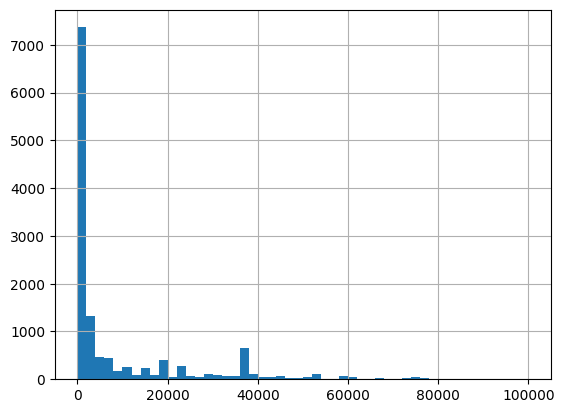

In [69]:
frauddf['AMOUNT_USD'].hist(bins=50, range=[0, 100000])

<Axes: >

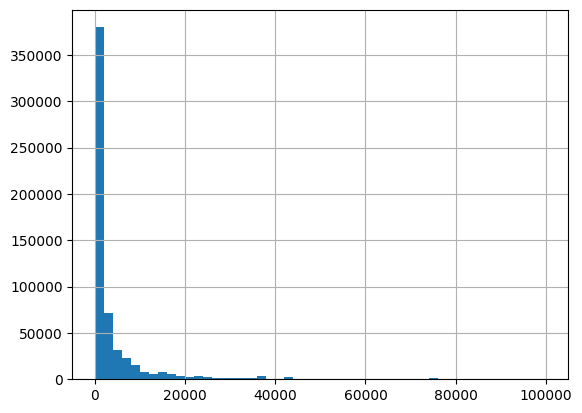

In [70]:
df['AMOUNT_USD'].hist(bins=50, range=[0, 100000]) 
# A slight observed difference in the distribution of fraud and nonfraud transactions

We create a reduced dataframe where we drop features that at face value seem irrelevant to make the analysis somewhat simpler.

In [81]:
reduceddf = df[[#'ID_x', 'HAS_EMAIL', 
        'PHONE_COUNTRY', 'IS_FRAUDSTER', 
        #'TERMS_VERSION',
        #'CREATED_DATE_x', 'STATE_x', 
        'COUNTRY', #'BIRTH_YEAR', 
        'KYC',
        #'FAILED_SIGN_IN_ATTEMPTS', 
        'CURRENCY', 'AMOUNT', 'STATE_y',
        #'CREATED_DATE_y', 
        #'MERCHANT_CATEGORY', 'MERCHANT_COUNTRY',
       'ENTRY_METHOD', 
        #'USER_ID', 'TYPE', 'SOURCE', 'ID_y', 'AMOUNT_USD'
        ]]

reduceddf.head()

,PHONE_COUNTRY,IS_FRAUDSTER,COUNTRY,KYC,CURRENCY,AMOUNT,STATE_y,ENTRY_METHOD
0,GB||JE||IM||GG,False,GB,PASSED,GBP,50000.0,COMPLETED,misc
1,GB||JE||IM||GG,False,GB,PASSED,EUR,25000.0,COMPLETED,chip
2,GB||JE||IM||GG,False,GB,PASSED,EUR,2220.0,COMPLETED,chip
3,GB||JE||IM||GG,False,GB,PASSED,EUR,1190.0,COMPLETED,cont
4,GB||JE||IM||GG,False,GB,PASSED,GBP,1000.0,COMPLETED,misc


## Model Selection <a name="chapter2"></a>

### Logistic Model <a name="section_2_1"></a>

In [72]:
#Logistic regression using the selected features
reduceddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   PHONE_COUNTRY  638742 non-null  object
 1   IS_FRAUDSTER   638742 non-null  bool  
 2   COUNTRY        638742 non-null  object
 3   KYC            638742 non-null  object
 4   CURRENCY       638742 non-null  object
 5   AMOUNT         638742 non-null  int64 
 6   STATE_y        638742 non-null  object
 7   ENTRY_METHOD   638742 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 39.6+ MB


In [73]:
phone_dummie = pd.get_dummies(reduceddf.PHONE_COUNTRY,prefix='phone',drop_first=True)
country_dummie = pd.get_dummies(reduceddf.COUNTRY ,prefix='country',drop_first=True)
kyc_dummie = pd.get_dummies(reduceddf.KYC,prefix='KYC',drop_first=True)
CURRENCY_dummie = pd.get_dummies(reduceddf.CURRENCY,prefix='Currency',drop_first=True)
State_dummie = pd.get_dummies(reduceddf.STATE_y ,prefix='State',drop_first=True)
entry_dummie = pd.get_dummies(reduceddf.ENTRY_METHOD,prefix='entrymethod',drop_first=True)
df["AMOUNT"] = pd.to_numeric(df["AMOUNT"], downcast="float")

In [74]:
newdata = pd.concat([phone_dummie,country_dummie, kyc_dummie, CURRENCY_dummie, State_dummie, entry_dummie],axis=1)
X = newdata
y = df.IS_FRAUDSTER
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [75]:
def evaluation(y_test, y_pred):
    print('Accuracy: '  + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))

Accuracy: 0.9815826058640081
Recall: 0.16714864083285136
F1 Score: 0.2821576763485477
Precision: 0.9045383411580594


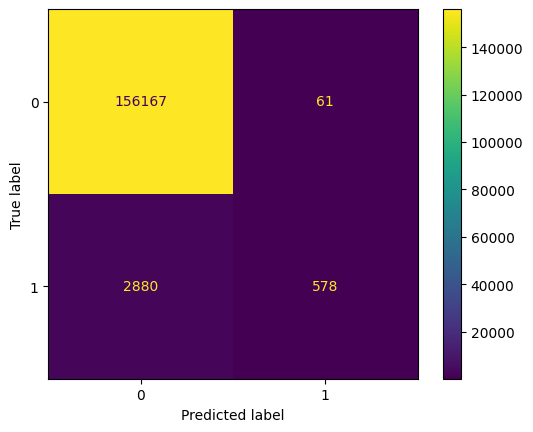

In [76]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
evaluation(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [77]:
coef = pd.DataFrame(zip(X_train.columns, np.transpose(lr.coef_)), columns=['features', 'coef'])
coef['coefabs'] = abs(coef['coef'])
coef.sort_values(by='coefabs', ascending=False).head(10)

,features,coef,coefabs
59,phone_PT,[6.572922630008665],[6.572922630008665]
79,country_DE,[6.558551028137909],[6.558551028137909]
109,country_PT,[-5.72364358983604],[5.72364358983604]
15,phone_DE,[-5.638069958154218],[5.638069958154218]
116,KYC_NONE,[-5.096089539276917],[5.096089539276917]
118,KYC_PENDING,[3.2521093574689854],[3.2521093574689854]
61,phone_RO,[3.1613749783471414],[3.1613749783471414]
127,Currency_GBP,[2.768899809524903],[2.768899809524903]
23,phone_GB||JE||IM||GG,[2.653689343223172],[2.653689343223172]
20,phone_ES,[2.550590263072773],[2.550590263072773]


We see that Germany and Portugal have high coefficients, however with both country and phone included the effects seem to cancel out if the transaction has both values equal to one of these countries. Most interesting is perhaps the effect of the KYC. An interpretation is that if KYC_NONE is 1 (True) then the odds is multiplied by $$\exp(-5.09) \approx 0.006$$. In other words, no KYC implies that the odds of the transaction being fraudulent is very low (while KYC = pending increases the odds drastically).

### Random Forest <a name="section_2_2"></a>

0.9808749671229788
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    156228
        True       0.92      0.13      0.22      3458

    accuracy                           0.98    159686
   macro avg       0.95      0.56      0.61    159686
weighted avg       0.98      0.98      0.97    159686



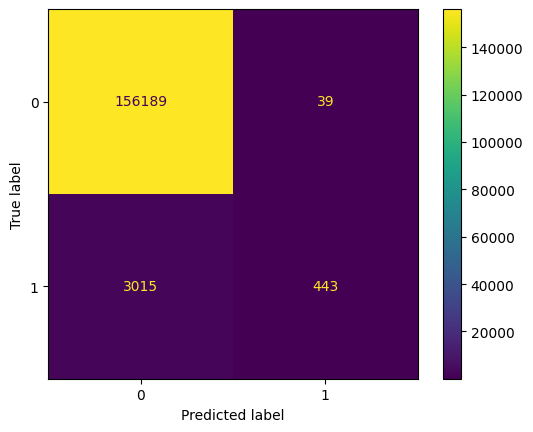

In [78]:
#Tree Classifier with max leaf nodes = 3
tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes= 3, random_state=2)

tree_3_leaf.fit(X_train, y_train)
y_predict = tree_3_leaf.predict(X_test)

print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Confusion matrix
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

<IPython.core.display.Javascript object>

0.9818769334819584
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    156228
        True       0.92      0.18      0.30      3458

    accuracy                           0.98    159686
   macro avg       0.95      0.59      0.65    159686
weighted avg       0.98      0.98      0.98    159686



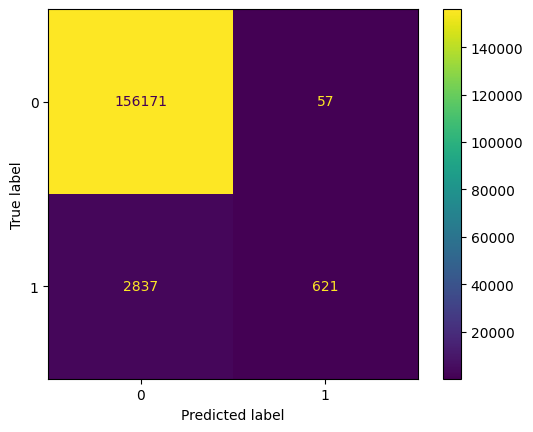

In [82]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=2)

rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

# Confusion matrix
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Feedforward Neural Network <a name="section_2_3"></a>

In [83]:
# Fitting a neural network

x_train = tf.keras.utils.normalize(X_train, axis=1)
x_test = tf.keras.utils.normalize(X_test, axis=1)

# Defining a simple feedforward neural network
model = Sequential()
model.add(Dense(12, input_shape=(158,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=10)
accuracy = model.evaluate(x_test, y_test)
print('Accuracy: ', accuracy[1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/4
47906/47906 [==============================] - 52s 1ms/step - loss: 0.0797 - accuracy: 0.9813
Epoch 2/4
47906/47906 [==============================] - 52s 1ms/step - loss: 0.0772 - accuracy: 0.9817
Epoch 3/4
47906/47906 [==============================] - 52s 1ms/step - loss: 0.0770 - accuracy: 0.9817
Epoch 4/4
4991/4991 [==============================] - 5s 1ms/step - loss: 0.0766 - accuracy: 0.9818
Accuracy:  0.9817892909049988


## Conclusion <a name="chapter3"></a>

We were able to create some models performing slightly better than the naive prediction of guessing that every transaction was nonfraud (which would have a 97% accuracy, compared to our 98.xx % accuracy from our models).

For further work, it could make sense to balance the distribution between nonfraud and fraud transactions, as I would assume detecting fraud transactions would be the key concern. One could also tune the hyperparameters in the neural net, use AIC to select a smaller logistic model, consider other models etc... depending on domain knowledge and time constraints.